### Import Libraries and Data

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

In [2]:
#Remove /resources/data
df = pd.read_csv("multipleChoiceResponses.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
list(df.columns[0:5])

['Time from Start to Finish (seconds)', 'Q1', 'Q1_OTHER_TEXT', 'Q2', 'Q3']

Since the first row is not informative, I re-read the data and set the second row as the column header of the dataframe.
Since only have 13k samples, rule of 10n means I should only have a maximum of 1.3k features. With 395 columns, I am choosing ones I feel are most relevent

In [4]:
df = pd.read_csv("multipleChoiceResponses.csv",header=1)
#Drop rows missing target variable
df.dropna(subset=['What is your current yearly compensation (approximate $USD)?'],inplace=True)
# Remove rows where salary is not disclosed
df = df[df['What is your current yearly compensation (approximate $USD)?']!= "I do not wish to disclose my approximate yearly compensation"]
#Drop first column as it's not the index
df.drop(df.columns[0],axis=1,inplace=True)
#Drop any column with all NaN values
df.dropna(axis=1,how='all',inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (157,172,174,210,218,219,246,368,371,384,389,390,391,393) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Now have more meaningful dataframe column names
list(df.columns[0:5])

['What is your gender? - Selected Choice',
 'What is your gender? - Prefer to self-describe - Text',
 'What is your age (# years)?',
 'In which country do you currently reside?',
 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?']

In [6]:
df.describe()

,What is your gender? - Prefer to self-describe - Text,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text,Select any activities that make up an important part of your role at work: (Select all that apply) - Other - Text,"What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Advanced statistical software (SPSS, SAS, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Business intelligence software (Salesforce, Tableau, Spotfire, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Local or hosted development environments (RStudio, JupyterLab, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Cloud-based data software & APIs (AWS, GCP, Azure, etc.) - Text",What is the primary tool that you use at work or school to analyze data? (include text response) - Other - Text,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Other - Text,Which of the following hosted notebooks have you used at work or school in the last 5 years? (Select all that apply) - Other - Text,Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Other - Text,What programming languages do you use on a regular basis? (Select all that apply) - Other - Text,What specific programming language do you use most often? - Other - Text,What programming language would you recommend an aspiring data scientist to learn first? - Other - Text,What machine learning frameworks have you used in the past 5 years? (Select all that apply) - Other - Text,"Of the choices that you selected in the previous question, which ML library have you used the most? - Other - Text",What data visualization libraries or tools have you used in the past 5 years? (Select all that apply) - Other - Text,"Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Other - Text",Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Other - Text,Which of the following machine learning products have you used at work or school in the last 5 years? (Select all that apply) - Other - Text,Which of the following relational database products have you used at work or school in the last 5 years? (Select all that apply) - Other - Text,Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that apply) - Other - Text,Which types of data do you currently interact with most often at work or school? (Select all that apply) - Other Data - Text,What is the type of data that you currently interact with most often at work or school? - Other Data - Text,Where do you find public datasets? (Select all that apply) - Other - Text,"During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Gathering data","During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Cleaning data","During a typical data science project at work or school, approximately what proportion of your time is devoted to the following? (Answers must add up to 100%) - Visualizing data","During a typical data science project at work or 


## 1. Data Cleaning
----

Clearly, many columns having missing/null values.

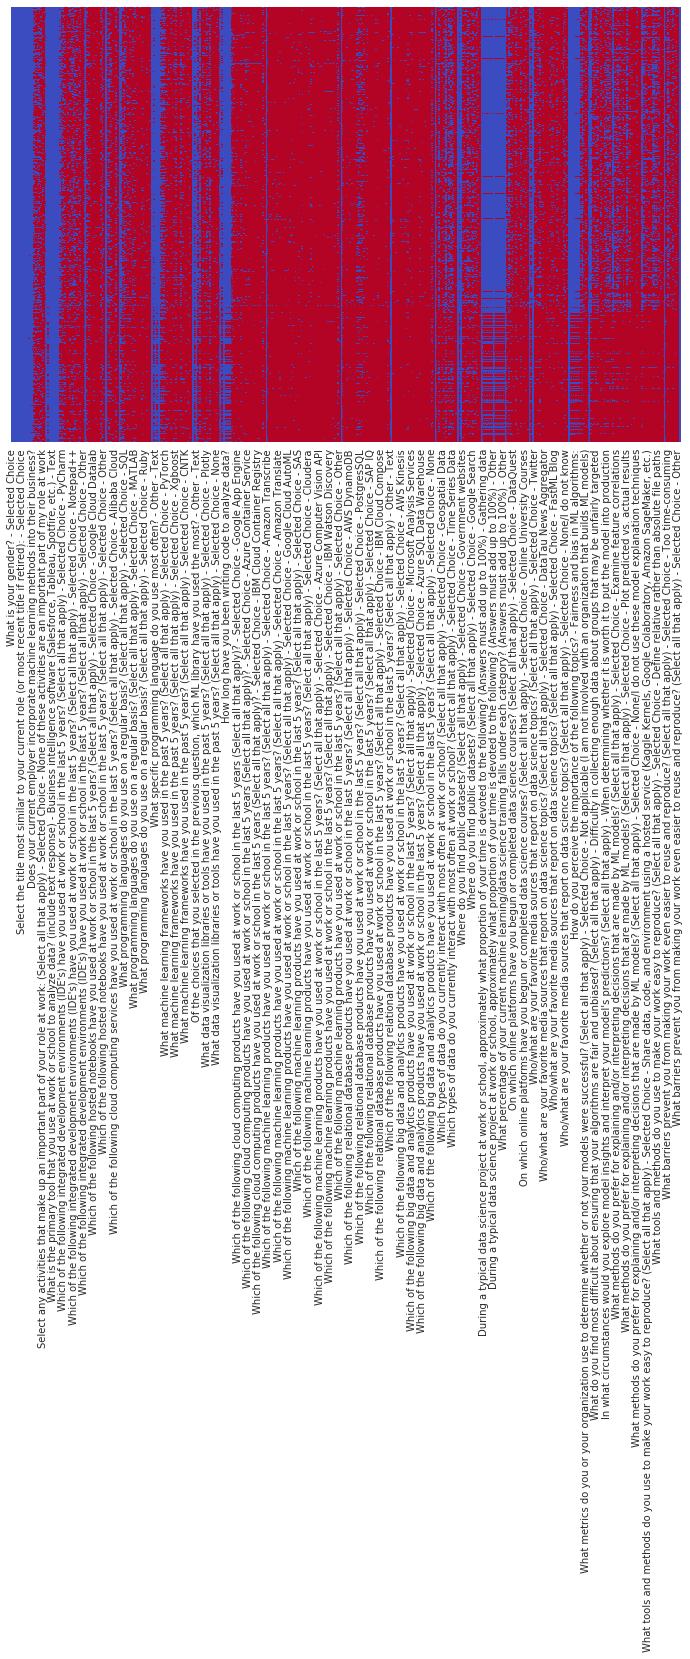

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

The following columns have samples with missing values: 
- Undergrad, 135
- Years Experience in Current Role, 76
- Does your current employer incorporate machine learning methods into their business?, 292

In [8]:
#Show number of missing values for each data column
missingvalue = df.isnull().sum(axis = 0)
print(missingvalue)

What is your gender? - Selected Choice                                                                                                                                                                      0
What is your gender? - Prefer to self-describe - Text                                                                                                                                                       0
What is your age (# years)?                                                                                                                                                                                 0
In which country do you currently reside?                                                                                                                                                                   0
What is the highest level of formal education that you have attained or plan to attain within the next 2 years?                                                                 

For the null values in the Undergrad column, they are all because the highest level of education completed was high school and thus they never had an undergrad. Therefore fill the null values in the Undergrad column with 'No Undergrad'. Note: I chose not to fill the null values with existing values such as 'Other' or 'I never declared a major' because that means you still attended university.

In [9]:
df[(df['Which best describes your undergraduate major? - Selected Choice'].isnull())]

,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe - Text,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text,How many years of experience do you have in your current role?,What is your current yearly compensation (approximate $USD)?,Does your current employer incorporate machine learning methods into their business?,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other,Select any activities that make up an important part of your role at work: (Select all that apply) - Other - Text,What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice,"What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Advanced statistical software (SPSS, SAS, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Business intelligence software (Salesforce, Tableau, Spotfire, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Local or hosted development environments (RStudio, JupyterLab, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Cloud-based data software & APIs (AWS, GCP, Azure, etc.) - Text",What is the primary tool that you use at work or school to analyze data? (include text response) - Other - Text,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Jupyter/IPython,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - RStudio,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice

In [0]:
# Set value of null Undergraduate major
df.at[df['Which best describes your undergraduate major? - Selected Choice'].isnull(), 'Which best describes your undergraduate major? - Selected Choice'] = 'No Undergrad'

In [11]:
# Verify
df[(df['Which best describes your undergraduate major? - Selected Choice'].isnull())]

,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe - Text,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text,How many years of experience do you have in your current role?,What is your current yearly compensation (approximate $USD)?,Does your current employer incorporate machine learning methods into their business?,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other,Select any activities that make up an important part of your role at work: (Select all that apply) - Other - Text,What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice,"What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Advanced statistical software (SPSS, SAS, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Business intelligence software (Salesforce, Tableau, Spotfire, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Local or hosted development environments (RStudio, JupyterLab, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Cloud-based data software & APIs (AWS, GCP, Azure, etc.) - Text",What is the primary tool that you use at work or school to analyze data? (include text response) - Other - Text,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Jupyter/IPython,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - RStudio,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice

For years experience in role, use the mode since the most common years is 0 to 1, and nearly all of these people earn a low salary and almost all are students/ in academia.

In [12]:
#Mode of years of experience
df['How many years of experience do you have in your current role?'].mode()[0]

'0-1'

In [13]:
#Rows with null values for years of experience
df[(df['How many years of experience do you have in your current role?'].isnull())]

,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe - Text,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text,How many years of experience do you have in your current role?,What is your current yearly compensation (approximate $USD)?,Does your current employer incorporate machine learning methods into their business?,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other,Select any activities that make up an important part of your role at work: (Select all that apply) - Other - Text,What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice,"What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Advanced statistical software (SPSS, SAS, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Business intelligence software (Salesforce, Tableau, Spotfire, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Local or hosted development environments (RStudio, JupyterLab, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Cloud-based data software & APIs (AWS, GCP, Azure, etc.) - Text",What is the primary tool that you use at work or school to analyze data? (include text response) - Other - Text,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Jupyter/IPython,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - RStudio,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice

Since only 14 samples have a salary greater than 10k and null values for years of experience, I feel it's safe to use the mode 0-1 years to fill the null values

In [14]:
df_years_null = df[(df['How many years of experience do you have in your current role?'].isnull())]
df_years_null_makes_not0 = df_years_null[df_years_null['What is your current yearly compensation (approximate $USD)?'] != '0-10,000']
print(df_years_null_makes_not0)

      What is your gender? - Selected Choice  ...  What barriers prevent you from making your work even easier to reuse and reproduce? (Select all that apply) - Other - Text
12                                      Male  ...                                                 -1                                                                         
1153                                  Female  ...                                                 16                                                                         
1417                                    Male  ...                                                 -1                                                                         
2100                                  Female  ...                                                 -1                                                                         
3577                                    Male  ...                                                 -1                              

In [15]:
df.at[df['How many years of experience do you have in your current role?'].isnull(), 'How many years of experience do you have in your current role?'] = df['How many years of experience do you have in your current role?'].mode()[0]
# Verify
df[(df['How many years of experience do you have in your current role?'].isnull())]

,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe - Text,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,Which best describes your undergraduate major? - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Select the title most similar to your current role (or most recent title if retired): - Other - Text,In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice,In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text,How many years of experience do you have in your current role?,What is your current yearly compensation (approximate $USD)?,Does your current employer incorporate machine learning methods into their business?,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,"Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other,Select any activities that make up an important part of your role at work: (Select all that apply) - Other - Text,What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice,"What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Advanced statistical software (SPSS, SAS, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Business intelligence software (Salesforce, Tableau, Spotfire, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Local or hosted development environments (RStudio, JupyterLab, etc.) - Text","What is the primary tool that you use at work or school to analyze data? (include text response) - Cloud-based data software & APIs (AWS, GCP, Azure, etc.) - Text",What is the primary tool that you use at work or school to analyze data? (include text response) - Other - Text,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Jupyter/IPython,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - RStudio,Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice

For the 292 samples with null values for "Does your current employer incorporate machine learning methods into their business?", the compensation is very diverse so I will remove these samples. 

In [16]:
df = df.dropna(subset=["Does your current employer incorporate machine learning methods into their business?"])
print('After droping NaN, the new dimension is:',df.shape)

After droping NaN, the new dimension is: (15137, 392)


Removed all features that include "- Text" or "- Other" in their name as these are unique comments made by surveyors the number of characters in the comment which is not useful.

In [17]:
df.drop([col for col in df.columns if '- Text' in col or "- Other in" in col],axis=1,inplace=True)
print('After removing columns with -Text or -Other in title there are', df.shape[1], 'columns')

After removing columns with -Text or -Other in title there are 356 columns


In [18]:
binaryCols = []
for col in df.columns:
    if len(df[col].unique()) == 2:
        binaryCols.append(col)
print(len(binaryCols))
print(binaryCols)

313
['Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions', 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows', 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data', 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas', 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of t

For features with only one unique value (essentially the features that contain 'Selected Choice') it indicates a binary variable.Therefore, fill null values with 0 and non-null values with 1.

In [0]:
for binaryVar in binaryCols:
    df.at[df[binaryVar].isnull(), binaryVar] = 0
    df.at[df[binaryVar].notnull(), binaryVar] = 1

List all features that are not binary variables

In [20]:
non_binaryCols = []
for col in df.columns:
    if len(df[col].unique()) > 2:
        non_binaryCols.append(col)
    
print(len(non_binaryCols))
print(non_binaryCols)

43
['What is your gender? - Selected Choice', 'What is your age (# years)?', 'In which country do you currently reside?', 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?', 'Which best describes your undergraduate major? - Selected Choice', 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice', 'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice', 'How many years of experience do you have in your current role?', 'What is your current yearly compensation (approximate $USD)?', 'Does your current employer incorporate machine learning methods into their business?', 'What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice', 'What specific programming language do you use most often? - Selected Choice', 'What programming language would you recommend an aspiring

For the non-binary features that have many null values, I will drop them. An alternative is to replace the null values with a text value 'missing' however this would introduce bias since the data is not missing at random.

In [21]:
for non_binaryVar in non_binaryCols:
    missingValue = df[non_binaryVar].isnull().sum(axis = 0)
    if missingValue != 0:
        #Drop the non-binary feature if it has missing values
        df.drop(non_binaryVar, axis = 1, inplace=True)
    #Print the number of missing values for each non-binary feature
    print(missingValue, non_binaryVar)
print(df.shape)

0 What is your gender? - Selected Choice
0 What is your age (# years)?
0 In which country do you currently reside?
0 What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
0 Which best describes your undergraduate major? - Selected Choice
0 Select the title most similar to your current role (or most recent title if retired): - Selected Choice
0 In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice
0 How many years of experience do you have in your current role?
0 What is your current yearly compensation (approximate $USD)?
0 Does your current employer incorporate machine learning methods into their business?
1280 What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice
4049 What specific programming language do you use most often? - Selected Choice
1530 What programming language would you recommend an aspiring data 

Dataset has no null values

(15137, 324)


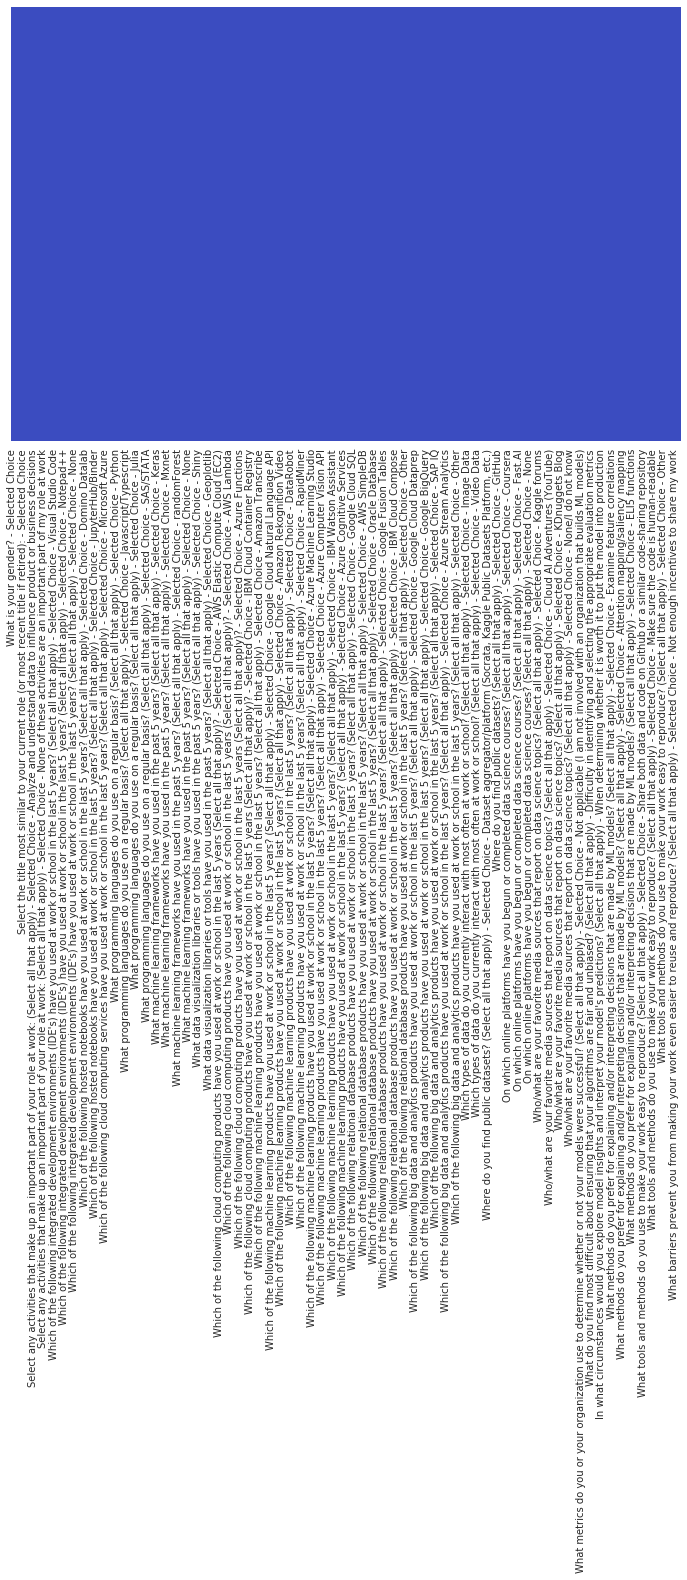

In [22]:
print(df.shape)
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

### Encoding
Convert non-ordinal categorical features with one hot encoding as scikit-learn requires numeric values. 

Use label encoding for ordinal features: Age and Years of Experience, and for the target variable (which is also ordinal), since to want to imply an ordered relationship for these three columns.

In [0]:
#Rename columns 
df = df.rename(columns = {'What is your current yearly compensation (approximate $USD)?':'Compensation',
                          'What is your gender? - Selected Choice':'Gender',
                          'What is your age (# years)?':'Age',
                          'In which country do you currently reside?':'Country',
                          'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?':'Education',
                          'Which best describes your undergraduate major? - Selected Choice':'Undergrad',
                          'Select the title most similar to your current role (or most recent title if retired): - Selected Choice':'Title',
                          'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice':'Industry',
                          'How many years of experience do you have in your current role?':'Years',
                          'Does your current employer incorporate machine learning methods into their business?':'IncorporateMLMethods'})

In [24]:
list(df.columns[0:20])

['Gender',
 'Age',
 'Country',
 'Education',
 'Undergrad',
 'Title',
 'Industry',
 'Years',
 'Compensation',
 'IncorporateMLMethods',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas',
 'Select any activities tha

In [25]:
#One hot encoding
# Create dummy features for each categorical feature
dummies_Gender = pd.get_dummies(df['Gender'], prefix='Gender')
#dummies_Age = pd.get_dummies(df['Age'], prefix='Age')
dummies_Country = pd.get_dummies(df['Country'], prefix='Country')
dummies_Education = pd.get_dummies(df['Education'], prefix='Education')
dummies_Undergrad = pd.get_dummies(df['Undergrad'], prefix='Undergrad')
dummies_Title = pd.get_dummies(df['Title'], prefix='Title')
#dummies_Years = pd.get_dummies(df['Years'], prefix='Years')
dummies_IncorporateMLMethod = pd.get_dummies(df['IncorporateMLMethods'], prefix='IncorporateMLMethods')

# Add the new features to the dataframe via concating, enc for encoding
df_enc = pd.concat([df,dummies_Gender,dummies_Country,dummies_Education,dummies_Undergrad,dummies_Title,dummies_IncorporateMLMethod], axis=1)

# Drop the original categorical feature columns
df_enc = df_enc.drop(['Gender', 'Country','Education','Undergrad','Title','Industry','IncorporateMLMethods'],axis=1)

#Check
df_enc.head()
list(df_enc.columns)

['Age',
 'Years',
 'Compensation',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas',
 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do re

In [26]:
#Label encoder for Age,Years,Compensation
from sklearn.preprocessing import LabelEncoder
nbh = LabelEncoder()

nbh_labels=nbh.fit_transform(df_enc['Age'])
nbh_mappings={index: label for index, label in enumerate (nbh.classes_)}
print(list(nbh.classes_))
df_enc['Age_Label'] = nbh_labels
print(df_enc['Age_Label'])
del df_enc['Age']

#Can't use label encoder for age or compensation since assigns wrong ordering
year_order = {'0-1':0, '1-2':1, '2-3':2,'3-4':3,'4-5':4, '5-10':5, '10-15':6, '15-20':7,'20-25':8,'25-30':9,'30 +':10}
df_enc.replace({"Years": year_order},inplace=True)
print(df_enc['Years'])

#comp_order = {'0-10,000':'0', '10-20,000':'1', '20-30,000':'2', '30-40,000':'3', '40-50,000':'4', '50-60,000':'5', '500,000+':'6', '60-70,000':'7', '70-80,000':'8', '80-90,000':'9', '90-100,000':'10', '100-125,000':'11', '125-150,000':'12', '150-200,000':'13', '200-250,000':'14', '250-300,000':'15','300-400,000':'16','400-500,000':'17'}
comp_order = {'0-10,000':0, '10-20,000':1, '20-30,000':2, '30-40,000':3, '40-50,000':4, '50-60,000':5, '500,000+':6, '60-70,000':7, '70-80,000':8, '80-90,000':9, '90-100,000':10, '100-125,000':11, '125-150,000':12, '150-200,000':13, '200-250,000':14, '250-300,000':15,'300-400,000':16,'400-500,000':17}
df_enc.replace({"Compensation": comp_order},inplace=True)
print(df_enc['Compensation'])

df_enc.rename(columns={'Years': 'Years_Label', 'Compensation':'Compensation_Label'},inplace=True)

['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70-79', '80+']
1        3
2        3
4        1
6        4
7        0
        ..
23840    1
23841    0
23843    3
23854    6
23856    1
Name: Age_Label, Length: 15137, dtype: int64
1        5
2        0
4        0
6        6
7        0
        ..
23840    8
23841    0
23843    6
23854    5
23856    0
Name: Years, Length: 15137, dtype: int64
1         1
2         0
4         0
6         1
7         0
         ..
23840     1
23841     0
23843    10
23854    15
23856     1
Name: Compensation, Length: 15137, dtype: int64


## 2. Exploratory Data Analysis

This is a ordinal category prediction problem. The target variable is not continuous.

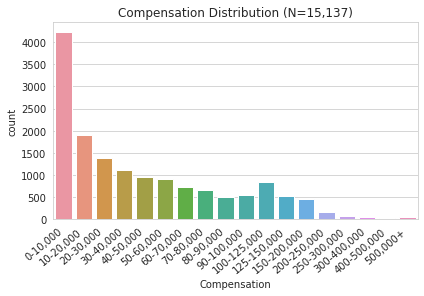

<Figure size 576x864 with 0 Axes>

In [27]:
ax = sns.countplot(x='Compensation',data=df,
                   order=['0-10,000','10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000','70-80,000',
                          '80-90,000','90-100,000','100-125,000','125-150,000','150-200,000','200-250,000','250-300,000'
                          ,'300-400,000','400-500,000','500,000+'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha="right")
plt.tight_layout()
plt.title("Compensation Distribution (N=15,137)")
plt.figure(figsize=(8,12))
plt.show()

For the target variable salary, there is a right tail skewness, with the majority of surveyors earning less than 125k/year and a large proportion(28.5%) earning less than 10k/year (students and job seekers).

In [28]:
dfSalary = df['Compensation'].value_counts()/len(df)
dfSalary = dfSalary.reindex(['0-10,000','10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000','70-80,000',
                          '80-90,000','90-100,000','100-125,000','125-150,000','150-200,000','200-250,000','250-300,000'
                          ,'300-400,000','400-500,000','500,000+'])
dfSalary

0-10,000       0.279778
10-20,000      0.125983
20-30,000      0.090771
30-40,000      0.072802
40-50,000      0.063355
50-60,000      0.059985
60-70,000      0.047566
70-80,000      0.044328
80-90,000      0.033428
90-100,000     0.036731
100-125,000    0.055361
125-150,000    0.034947
150-200,000    0.029861
200-250,000    0.011297
250-300,000    0.004889
300-400,000    0.003435
400-500,000    0.001453
500,000+       0.004030
Name: Compensation, dtype: float64

Americans make much more than Indians and Chinese.

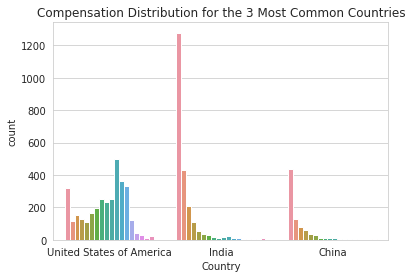

<Figure size 1080x576 with 0 Axes>

In [29]:
ax = sns.countplot(x='Country',data=df,
                   hue_order=['0-10,000','10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000','70-80,000',
                          '80-90,000','90-100,000','100-125,000','125-150,000','150-200,000','200-250,000','250-300,000'
                          ,'300-400,000','400-500,000','500,000+'],hue='Compensation',order=df['Country'].value_counts().iloc[:3].index)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha="right")
#plt.tight_layout()
ax.get_legend().remove()
ax.set_title('Compensation Distribution for the 3 Most Common Countries')
ax.set_xlabel('Country')
plt.figure(figsize=(15,8))
plt.show()

A high number of bachelors and master's degree holders make <10k, while a lower proportion of doctoral degree holder make <10k

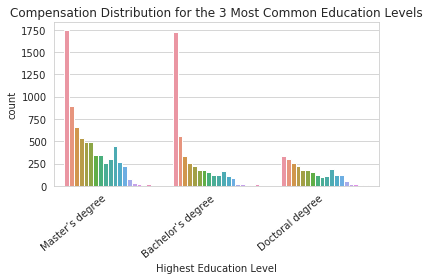

<Figure size 576x864 with 0 Axes>

In [30]:
ax = sns.countplot(x='Education',data=df,
                   hue_order=['0-10,000','10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000','70-80,000',
                          '80-90,000','90-100,000','100-125,000','125-150,000','150-200,000','200-250,000','250-300,000'
                          ,'300-400,000','400-500,000','500,000+'],hue='Compensation',order=df['Education'].value_counts().iloc[:3].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha="right")
ax.get_legend().remove()
ax.set_xlabel('Highest Education Level')
ax.set_title('Compensation Distribution for the 3 Most Common Education Levels')
plt.tight_layout()
plt.figure(figsize=(8,12))
plt.show()

For the five most common age groups, it's clear as you get older the more you make. Students don't make much.

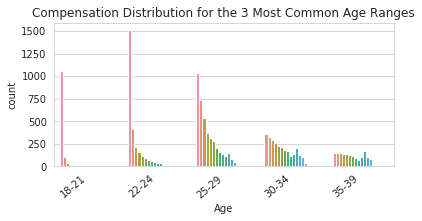

<Figure size 576x864 with 0 Axes>

In [31]:
ax = sns.countplot(x='Age',data=df,
                   hue_order=['0-10,000','10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000','70-80,000',
                          '80-90,000','90-100,000','100-125,000','125-150,000','150-200,000','200-250,000','250-300,000'
                          ,'300-400,000','400-500,000','500,000+'],hue='Compensation',order=['18-21','22-24','25-29','30-34','35-39'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha="right")
ax.set_title('Compensation Distribution for the 3 Most Common Age Ranges')
plt.tight_layout()
ax.get_legend().remove()
plt.figure(figsize=(8,12))
plt.show()

The most correlated features (absolute correlation) with the target variable, Compensation are:
- Country_United States of America
- Age_Label                                                                                                                                           
- Title_Student
- Years_Label
- Country_India

In [32]:
#Absolute correlation with compensation
df_enc.corr()['Compensation_Label'].abs().sort_values(ascending=False)[1:6]

Country_United States of America    0.486745
Age_Label                           0.479014
Title_Student                       0.355195
Years_Label                         0.306101
Country_India                       0.267282
Name: Compensation_Label, dtype: float64

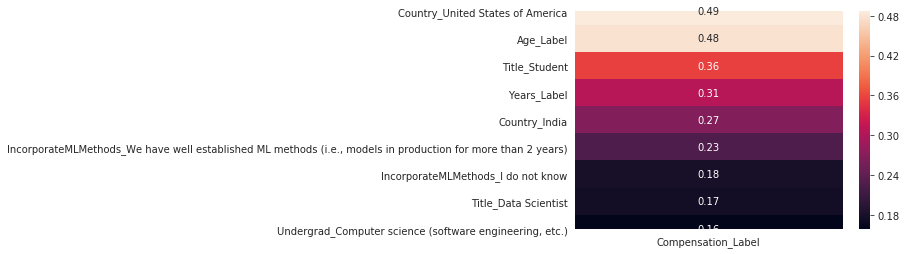

In [33]:
#Absolute Correlation Plot as Heatmap
corrVals = df_enc.corr()['Compensation_Label'].abs().sort_values(ascending=False)[1:10]
sns.heatmap(corrVals.to_frame(), annot=True)

In [34]:
#Top 10 Positively Correlated Features
df_enc.corr()['Compensation_Label'].sort_values(ascending=False)[1:11]

Country_United States of America                                                                                                                                          0.486745
Age_Label                                                                                                                                                                 0.479014
Years_Label                                                                                                                                                               0.306101
IncorporateMLMethods_We have well established ML methods (i.e., models in production for more than 2 years)                                                               0.225895
Title_Data Scientist                                                                                                                                                      0.174657
During a typical data science project at work or school, approximately what proportion of your time is de

In [35]:
#Top 10 Negatively Correlated Features
df_enc.corr()['Compensation_Label'].sort_values(ascending=True)[1:11]

Country_India                                             -0.267282
IncorporateMLMethods_I do not know                        -0.179833
Undergrad_Computer science (software engineering, etc.)   -0.158670
IncorporateMLMethods_No (we do not use ML methods)        -0.155708
Country_China                                             -0.140885
Education_Bachelor’s degree                               -0.140092
Country_Russia                                            -0.109237
Country_Other                                             -0.101758
Title_Research Assistant                                  -0.094318
Country_Brazil                                            -0.088575
Name: Compensation_Label, dtype: float64

## 3. Feature Selection

Feature engineering is the process of making features and allowing relationships in the data to be detected by the machine learning algorithms. These machine learning algorithms can't interpret text so feature engieering allows text/categorical variables to be interpretable.

For features selection can't use both Lasso Regression and PCA. So choose Lasso because it chooses features to predict the target. While PCA just does dimension reduction without considering the target. https://stats.stackexchange.com/questions/386385/can-i-use-pca-after-lasso-variable-selection. Lasso works by penalizing the size of the Betas (coefficients) for which can cause non-important feature coefficients to equal 0.

I could've have tuned C for the feature selection as well, but for the sake of computational efficiency I chose not to and used C=0.1. As C decreases, lambda (regularization) increases, so the number of features is reduced to 378 from the available 425. The pros of feature selection is that it reduces the number of variables allowing your model to generalize better. It also manage highly correlated features.

In [36]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
sel_ = SelectFromModel(LogisticRegression(penalty='l1', C=0.1))
y = df_enc['Compensation_Label']
X = df_enc.drop(['Compensation_Label'],axis=1)
sel_.fit(X, y)
print(sel_.get_support())
#Remove identified features
print("Before removing features, data has shape:",X.shape)
selectedX = sel_.transform(X)
print("After removing features, data has shape:",selectedX.shape)
#Convert nparray to dataframe
selectedX = pd.DataFrame(data=selectedX,columns=X.columns[sel_.get_support()],index=X.index)
#Scale feature set
scaler = StandardScaler()
X = scaler.fit_transform(selectedX)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True False
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True  True  True  True False  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

## Model Implementation (Commented Out)



TA stated we did not have to graph the probability of belonging to each of the salary buckets.

10 fold Cross Validation was performed for various values of C = [1, 0.1, 0.01, 0.001]

See code below for accuracy per fold, average accuracy and average accuracy std dev.

The model that performs the best is the one with the highest accuracy and lowest bias.

Relating performance to the bias-variance trade-off, the model is underfitting when C is low (high regularization, lambda is large) causing low variance but high bias. When C is large, the regularization parameter lambda is low and such there is overfitting causing high variance and low bias. I want to minimize both bias and variance. I chose to scale in the Feature Selection step since Euclidian distances are impacted by the relative size of each feature.

In this case, I should try higher values of C (10, 100) because the model still isn't overfitting since I have the best performance with C = 1.



#### 10 Fold Cross Validation with scaling, hyperparameter C = 1:
    - Average Accuracy: 35.7%
    - Average Std Dev: 5.2%
    
#### 10 Fold Cross Validation with scaling, hyperparameter C = 0.1:
    - Average Accuracy: 35.7%
    - Average Std Dev: 5.3%

#### 10 Fold Cross Validation with scaling, hyperparameter C = 0.01:
    - Average Accuracy: 35.5%
    - Average Std Dev: 5.6%

#### 10 Fold Cross Validation with scaling, hyperparameter C = 0.001:
    - Average Accuracy: 35.1%
    - Average Std Dev: 5.5%

In [0]:
#10 fold cross validation function, hyperparameter used is C
#def TenFoldCV(Cval,X,y):
    #model = LogisticRegression(multi_class='ovr', C=Cval)
    
    #10 fold cross validation
    #seed = 8
    #kfold = model_selection.KFold(n_splits=10, random_state=seed)
    #scoring = 'accuracy'
    #results = model_selection.cross_val_score(model,X,y,cv=kfold,scoring = scoring)
    #print("***C = "+str(Cval)+"***")
    #print("Accuracy of each fold: " + str(results))
    #print("Average accuracy across all folds: " + str(round(results.mean(),3)))
    #print("Standard deviation of accuracy across all folds: " + str(round(results.std(),3)))
    #return

### Trying a different value of C, C=1, C=0.1, C = 0.01, C=0.001 (Commented Out)

In [0]:
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#TenFoldCV(1,X,y)
#TenFoldCV(0.1,X,y)
#TenFoldCV(0.01,X,y)
#TenFoldCV(0.001,X,y)

## 5. Model Tuning (Commented out)

The optimal logistic regression model uses C=0.001, and a newton-cg solver, and has a cross validation average accuracy of 33.442% with a standard deviation of 5.7%. Interestingly this is lower than my Question 4 average accuracy of 35.7%, however I will use the model found by grid search for Question 6.

In [0]:
#from sklearn.utils.testing import ignore_warnings
#from sklearn.exceptions import ConvergenceWarning
#ignore_warnings(category=ConvergenceWarning)
#y = y
#X = selectedX #Use unscaled feature set since the grid search code below will scale
#Grid Search
#model = LogisticRegression()
#scaler = StandardScaler()
#kfold = KFold(n_splits=10)
#kfold.get_n_splits(X)

#best_model = model
#best_params = {}
#best_accuracy = 0
#best_std = 0

#for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
  #  for solver in ['newton-cg','lbfgs','liblinear','sag']:
   #     model = LogisticRegression(C=C, multi_class='ovr', solver=solver)
    #    accuracy = np.zeros(10)
     #   np_idx = 0
      #  
       # for train_idx, test_idx in kfold.split(X):
        #    X_train, X_test = X.values[train_idx], X.values[test_idx]
         #   y_train, y_test = y.values[train_idx], y.values[test_idx]
#
 #           X_train = scaler.fit_transform(X_train)
  #          X_test = scaler.transform(X_test)
#
 #           model.fit(X_train, y_train)
#
 #           predictions = model.predict(X_test)
  #          accuracy[np_idx] = model.score(X_test,y_test)
#
 #           np_idx += 1
  #      
   #     if np.mean(accuracy) > best_accuracy:
    #        best_model = model
     #       best_params = {'C':C, 'solver':solver}
      #      best_accuracy = np.mean(accuracy)*100
       #     best_std = np.std(accuracy)*100

#print (best_params)
#print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

#print ("\nThe optimal logistic regression model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

Below is the precision, recall, f1-score for each compensation range for 1 of the 10 folds. Clearly, the model prefers to predict low compensations. F1-score considers both precision and recall, so it would be the best measure here to evaluate model performance.

In [0]:
#from sklearn.metrics import classification_report
#print(classification_report(y_test, predictions))

## 6. Testing and Discussion

The selected model achieves a test set accuracy of 32.3%. Since the training and test set accuracy are very close together, I believe the model is not overfitting. However, I can't make assumptions on if the model is underfitting without plotting the test accuracy vs. model complexity and viewing the curve to see where the lowest test error is. Overall, we want a model that generalizes well to make accurate predictions for unseen data.![alt text](https://i.stack.imgur.com/IpI8U.png).

In [41]:
#Use optimal solver and C value found from grid search
model = LogisticRegression(C=0.001, multi_class='ovr', solver='newton-cg')
#Use 90/10 train/test split as opposed to 70/30 split to match 10 fold cross validation split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy_train = model.score(X_train,y_train)
accuracy_test = model.score(X_test,y_test)
print("Training set accuracy: " + str(round(accuracy_train,3)*100) + "%")
print("Testing set accuracy: " + str(round(accuracy_test,3)*100) + "%")

Training set accuracy: 34.599999999999994%
Testing set accuracy: 32.300000000000004%


From the bar plots and confusion of actual and predicted values for the test set, it is clear the model is skewed towards predicting '0-10,000' and is unable to accurately predict higher compensation bins.

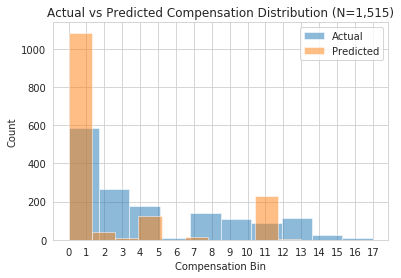

In [42]:
from matplotlib import pyplot
pyplot.hist(y_test, alpha=0.5, label='Actual')
pyplot.hist(predictions, alpha=0.5, label='Predicted')
pyplot.legend(loc='upper right')
pyplot.xlabel("Compensation Bin")
pyplot.ylabel("Count")
pyplot.title("Actual vs Predicted Compensation Distribution (N=1,515)")
pyplot.xticks(np.arange(0, 18, 1.0))
plt.show()

1514 samples


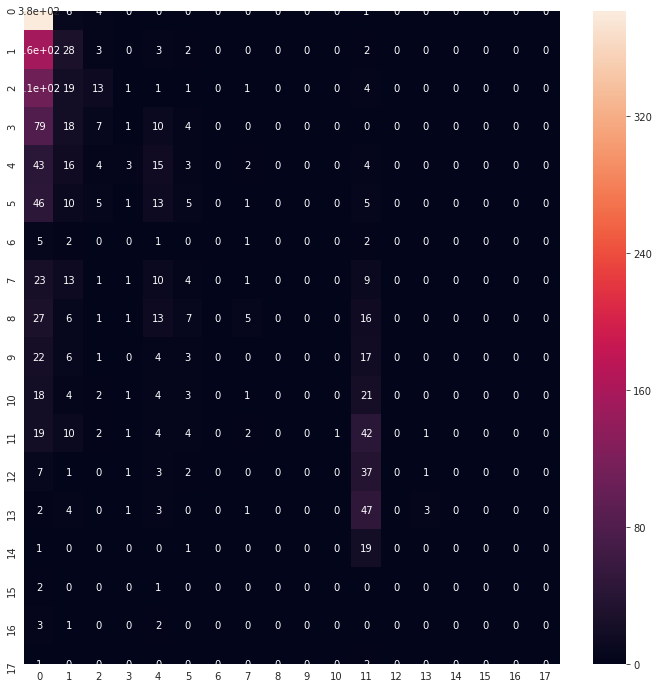

In [43]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(array, index = list(range(0,18)), columns = list(range(0,18)))
plt.figure(figsize = (12,12))
print(str(len(y_test))+" samples")
sns.heatmap(df_cm, annot=True)